## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)

This is a starter notebook for the guided project [Tweet Emotion Recognition with TensorFlow](https://www.coursera.org/projects/tweet-emotion-tensorflow)

A complete version of this notebook is available in the course resources

---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [ ]:
!pip install nlp
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Operation cancelled by user


In [ ]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.11.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
from datasets import load_dataset

dataset = load_dataset("dair-ai/emotion")

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [ ]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']
train[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [ ]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [ ]:
tweets, labels = get_tweet(train)

In [ ]:
tweets[1], labels[1]

('i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 0)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)


In [ ]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

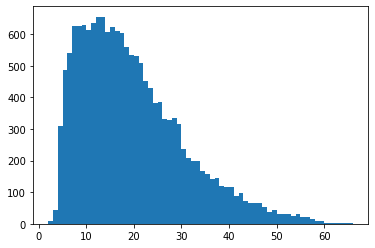

In [ ]:
lengths = [ len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins= len(set(lengths)))
plt.show()

In [ ]:
maxlen = 50 
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen = maxlen)
  return padded

In [ ]:
padded_train_seq = get_sequences(tokenizer, tweets)
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [ ]:
train_labels = np.array(np.array(labels))
train_labels[0]

0

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length = maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation= 'softmax')
])
model.compile(
    loss= 'sparse_categorical_crossentropy',
    optimizer='adam',
    metrics = ['accuracy']
)


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 50, 40)           5920      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [ ]:
val_tweets, vlabels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)


In [ ]:
val_labels =np.array(np.array(vlabels))

In [ ]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data = (val_seq, val_labels),
    epochs = 20,
    callbacks = [ tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
)

Epoch 1/20
500/500 [==============================] - 27s 41ms/step - loss: 1.2837 - accuracy: 0.5007 - val_loss: 0.8182 - val_accuracy: 0.6780
Epoch 2/20
500/500 [==============================] - 8s 16ms/step - loss: 0.5697 - accuracy: 0.7771 - val_loss: 0.6803 - val_accuracy: 0.7365
Epoch 3/20
500/500 [==============================] - 9s 17ms/step - loss: 0.3473 - accuracy: 0.8819 - val_loss: 0.4690 - val_accuracy: 0.8490
Epoch 4/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2491 - accuracy: 0.9205 - val_loss: 0.4348 - val_accuracy: 0.8585
Epoch 5/20
500/500 [==============================] - 8s 15ms/step - loss: 0.1827 - accuracy: 0.9436 - val_loss: 0.4349 - val_accuracy: 0.8745
Epoch 6/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1349 - accuracy: 0.9583 - val_loss: 0.4137 - val_accuracy: 0.8875
Epoch 7/20
500/500 [==============================] - 8s 16ms/step - loss: 0.1027 - accuracy: 0.9703 - val_loss: 0.4362 - val_accuracy: 0.880

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

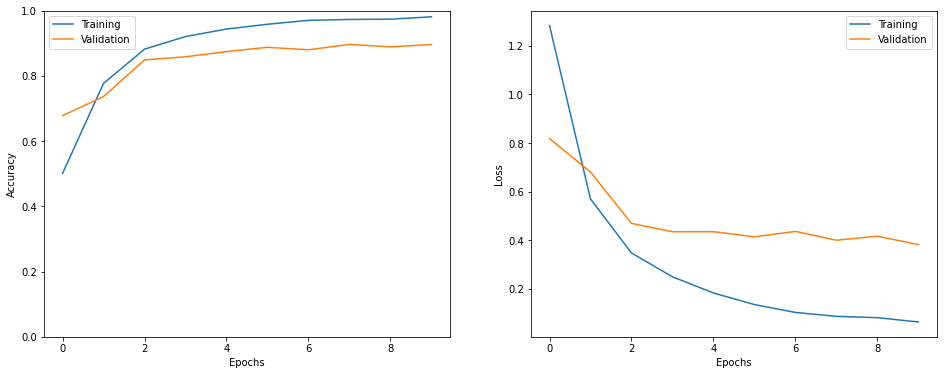

In [ ]:
show_history(h)

In [ ]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = np.array(np.array(test_labels))

In [ ]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.3827 - accuracy: 0.8875


In [ ]:
i = random.randint(0, len(test_labels)-1)
print('Sequence: ', test_tweets[i])
print('Emotion: ', test_labels[i])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = test_labels[np.argmax(p).astype('uint8')]
print('Predicted class = ', pred_class)

Sequence:  i feel that i am useful to my people and that gives me a great feeling of achievement
Emotion:  1
1/1 [==============================] - 1s 1s/step
Predicted class =  0


In [ ]:
preds = model.predict(test_seq)
classes1 = np.argmax(preds,axis=1)

63/63 [==============================] - 0s 7ms/step


ValueError: ignored

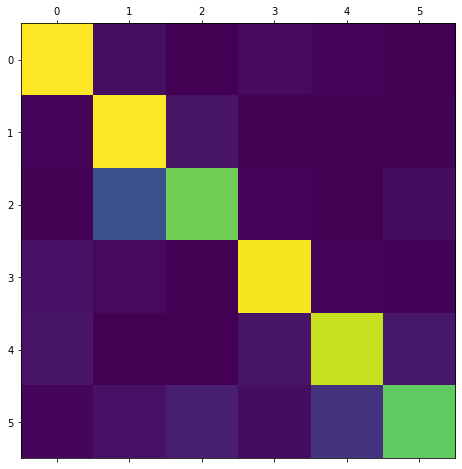

In [ ]:
show_confusion_matrix(test_labels, classes1, list(classes))